In [66]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import copy
import time

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [77]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(28),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.225, 0.225, 0.225))
])
test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.225, 0.225, 0.225))
])

In [78]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


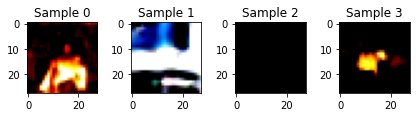

In [79]:
fig = plt.figure()

num_show = 4
for i in range(num_show):
    sample = train_dataset[i]
    ax = plt.subplot(1, num_show, i+1)
    plt.tight_layout()
    ax.set_title("Sample "+str(i))
    plt.imshow(sample[0].permute(1, 2, 0))

In [80]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [81]:
batch_size = 4
num_workers = 4
learning_rate = 0.003
num_epochs = 20
shuffle_train_loader = True

In [82]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train_loader, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [90]:
train_size = len(train_dataset)
test_size = len(test_dataset)

In [93]:
print('Train Size:', train_size)
print('Test Size:', test_size)

Train Size: 50000
Test Size: 10000


In [84]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    start_train_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print('-'*10)
        
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for i, (images, targets) in enumerate(train_dataloader):
            
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item() * len(targets)
            running_corrects += torch.sum(preds == targets)

            if (i+1) % 1000 == 0:
                print(f'Epoch: [{epoch+1}/{num_epochs}], Step [{i+1}/{train_size}], Loss = {loss.item()}')

        scheduler.step()
    
        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects / train_size
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))

        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for i, (images, targets) in enumerate(test_dataloader):

            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(False):
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, targets)

            running_loss += loss.item() * len(targets)
            running_corrects += torch.sum(preds == targets)

            if (i+1) % 1000 == 0:
                print(f'Epoch: [{epoch+1}/{num_epochs}], Step [{i+1}/{test_size}], Loss = {loss.item()}')

        epoch_loss = running_loss / test_size
        epoch_acc = running_corrects / test_size
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('Test', epoch_loss, epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_train_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [85]:
model = models.resnet101(pretrained=True)

In [86]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [87]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [88]:
model = train_model(model, criterion, optimizer, scheduler, 5)

Epoch 1/5
----------
Epoch: [1/5], Step [1000/12500], Loss = 1.3508851528167725
Epoch: [1/5], Step [2000/12500], Loss = 2.461912155151367
Epoch: [1/5], Step [3000/12500], Loss = 3.0593719482421875
Epoch: [1/5], Step [4000/12500], Loss = 2.384507894515991
Epoch: [1/5], Step [5000/12500], Loss = 1.9140831232070923
Epoch: [1/5], Step [6000/12500], Loss = 2.279144287109375
Epoch: [1/5], Step [7000/12500], Loss = 2.296881675720215
Epoch: [1/5], Step [8000/12500], Loss = 1.8988181352615356
Epoch: [1/5], Step [9000/12500], Loss = 2.7840471267700195
Epoch: [1/5], Step [10000/12500], Loss = 2.854389190673828
Epoch: [1/5], Step [11000/12500], Loss = 2.9364566802978516
Epoch: [1/5], Step [12000/12500], Loss = 1.843559980392456
Train Loss: 9.6567 Acc: 0.5795
Epoch: [1/5], Step [1000/2500], Loss = 2.742432117462158
Epoch: [1/5], Step [2000/2500], Loss = 2.236643075942993
Test Loss: 8.6986 Acc: 0.7396

Epoch 2/5
----------
Epoch: [2/5], Step [1000/12500], Loss = 1.9287344217300415
Epoch: [2/5], Step

In [97]:
def evaluate(model, criterion):

    start_time = time.time()

    running_loss = 0.0
    running_corrects = 0

    for i, (images, targets) in enumerate(test_dataloader):

        images = images.to(device)
        targets = targets.to(device)

        with torch.set_grad_enabled(False):

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, targets)

        running_loss += loss.item() * len(targets)
        running_corrects += torch.sum(preds == targets)

    total_loss = running_loss / test_size
    total_acc = running_corrects / test_size
    elapsed_time = time.time() - start_time

    print('###### SUMMARY ######')
    print('Elapsed Time: {}'.format(elapsed_time))
    print('Total Loss: {}'.format(total_loss))
    print('Total Acc : {}'.format(total_acc))

In [98]:
evaluate(model, criterion)

###### SUMMARY ######
Elapsed Time: 74.99072456359863
Total Loss: 1.7956983129501343
Total Acc : 0.33079999685287476


In [126]:
test_dataset.transform = transforms.ToTensor()

In [143]:
def visualization(model):

    num_show = 3
    fig = plt.figure()
    
    cnt = 1
    for k, (images, targets) in enumerate(test_dataloader):

        with torch.set_grad_enabled(False):
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)

        for i in range(len(images)):

            ax = plt.subplot(num_show, 4, 4*k+i+1)
            ax.set_title('{}[{}]'.format(classes[preds[i]], classes[targets[i]]))
            plt.imshow(images[i].permute(1, 2, 0))
            
        if cnt == num_show:
            return
        cnt += 1
    
    plt.show()

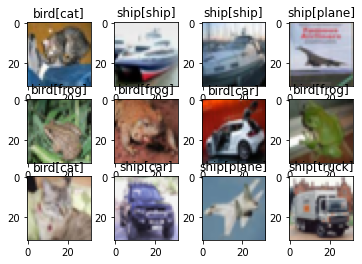

In [144]:
visualization(model)